In [1]:
pip install efinance pandas numpy datetime matplotlib seaborn 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import efinance as ef
import pandas as pd
import numpy as np
import datetime
import tkinter as tk
from tkinter import simpledialog
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# 设置Seaborn风格
sns.set(style="whitegrid")

In [3]:
def get_stock_data(stock_code, start_date, end_date):
    # 获取股票日线数据
    #df = pro.daily(ts_code=stock_code, start_date=start_date, end_date=end_date)
    df = ef.stock.get_quote_history(stock_code, start_date, end_date)
    #df = df.sort_values('日期', ascending=True)
    #df['日期'] = pd.to_datetime(df['日期'])
    #df.set_index('日期', inplace=True)
    return df

In [4]:
def calculate_technical_indicators(df):
    # 计算MACD
    df['EMA12'] = df['收盘'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['收盘'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_hist'] = df['MACD'] - df['MACD_signal']

    # 计算布林带
    df['MA20'] = df['收盘'].rolling(window=20).mean()
    df['MA5'] = df['收盘'].rolling(window=5).mean()
    df['MA10'] = df['收盘'].rolling(window=10).mean()
    df['STD20'] = df['收盘'].rolling(window=20).std()
    df['Upper_Band'] = df['MA20'] + 2 * df['STD20']
    df['Lower_Band'] = df['MA20'] - 2 * df['STD20']

    # 计算RSI
    delta = df['收盘'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    df['RSI'] = 100 - (100 / (1 + gain / loss))

    # 计算KDJ
    low_min = df['最低'].rolling(window=9).min()
    high_max = df['最高'].rolling(window=9).max()
    df['K'] = 100 * (df['收盘'] - low_min) / (high_max - low_min)
    df['D'] = df['K'].rolling(window=3).mean()
    df['J'] = 3 * df['K'] - 2 * df['D']

    # 计算5日均量和10日均量
    df['MA5_Volume'] = df['成交量'].rolling(window=5).mean()
    df['MA10_Volume'] = df['成交量'].rolling(window=10).mean()
    df['Volume_Ratio'] = df['成交量'] / df['MA10_Volume']

    return df

In [5]:
def market_analysis(df):
    latest_data = df.iloc[-1]

    # 判断当前趋势
    if latest_data['MACD'] > latest_data['MACD_signal']:
        trend = "上升"
    elif latest_data['MACD'] < latest_data['MACD_signal']:
        trend = "下降"
    else:
        trend = "盘整"

    # 判断市场强度
    if latest_data['RSI'] > 70:
        market_strength = "强"
    elif latest_data['RSI'] < 30:
        market_strength = "弱"
    else:
        market_strength = "中"

    # 判断爆发力
    if latest_data['Volume_Ratio'] > 1.5:
        explosive_power = "强"
    elif latest_data['Volume_Ratio'] > 1.0:
        explosive_power = "中"
    else:
        explosive_power = "弱"

    # 当日建议最大杠杆
    if market_strength == "强" and explosive_power == "强":
        max_leverage = 3.0
    elif market_strength == "中" and explosive_power == "中":
        max_leverage = 2.0
    else:
        max_leverage = 1.0

    return {
        "当前趋势": trend,
        "市场强度": market_strength,
        "爆发力": explosive_power,
        "当日建议最大杠杆": max_leverage
    }

In [6]:
def trade_execution_plan(df, market_status):
    latest_data = df.iloc[-1]

    # 交易方向
    if market_status["当前趋势"] == "上升":
        direction = "做多"
    elif market_status["当前趋势"] == "下降":
        direction = "做空"
    else:
        direction = "观望"

    # 建仓价格
    entry_price = latest_data['收盘']

    # 建仓仓位
    if market_status["市场强度"] == "强":
        position = 50.0  # 50%资金
    elif market_status["市场强度"] == "中":
        position = 30.0  # 30%资金
    else:
        position = 10.0  # 10%资金

    # 杠杆倍数
    leverage = market_status["当日建议最大杠杆"]

    # 首次止损
    if direction == "做多":
        stop_loss = entry_price * 0.95  # 5%止损
    else:
        stop_loss = entry_price * 1.05  # 5%止损

    # 首次止盈
    if direction == "做多":
        take_profit = entry_price * 1.10  # 10%止盈
    else:
        take_profit = entry_price * 0.90  # 10%止盈

    return {
        "交易方向": direction,
        "建仓价格": round(entry_price, 2),
        "建仓仓位": position,
        "杠杆倍数": leverage,
        "首次止损": round(stop_loss, 2),
        "首次止盈": round(take_profit, 2)
    }

In [7]:
def batch_entry_plan(df, trade_plan):
    latest_data = df.iloc[-1]

    # 第一批 (开盘时机)
    first_entry_price = latest_data['收盘']
    first_position = trade_plan["建仓仓位"] * 0.5  # 50%仓位
    first_leverage = trade_plan["杠杆倍数"]

    # 第二批 (盘中时机)
    second_entry_price = first_entry_price * 0.98 if trade_plan["交易方向"] == "做多" else first_entry_price * 1.02
    second_position = trade_plan["建仓仓位"] * 0.5  # 50%仓位
    second_leverage = trade_plan["杠杆倍数"]

    return {
        "第一批 (开盘时机)": {
            "触发价格": round(first_entry_price, 2),
            "仓位比例": round(first_position, 2),
            "杠杆倍数": first_leverage
        },
        "第二批 (盘中时机)": {
            "触发价格": round(second_entry_price, 2),
            "仓位比例": round(second_position, 2),
            "杠杆倍数": second_leverage
        }
    }

In [8]:
def profit_taking_plan(trade_plan):
    # 盈利加仓点位1
    take_profit_1 = trade_plan["首次止盈"]
    add_position_1 = trade_plan["建仓仓位"] * 0.2  # 20%加仓
    new_stop_loss_1 = take_profit_1 * 0.95 if trade_plan["交易方向"] == "做多" else take_profit_1 * 1.05

    # 盈利加仓点位2
    take_profit_2 = take_profit_1 * 1.05 if trade_plan["交易方向"] == "做多" else take_profit_1 * 0.95
    add_position_2 = trade_plan["建仓仓位"] * 0.1  # 10%加仓
    new_stop_loss_2 = take_profit_2 * 0.95 if trade_plan["交易方向"] == "做多" else take_profit_2 * 1.05

    return {
        "盈利加仓点位1": {
            "触发条件": round((take_profit_1 - trade_plan["建仓价格"]) / trade_plan["建仓价格"] * 100, 2),
            "加仓比例": round(add_position_1, 2),
            "新止损位": round(new_stop_loss_1, 2)
        },
        "盈利加仓点位2": {
            "触发条件": round((take_profit_2 - trade_plan["建仓价格"]) / trade_plan["建仓价格"] * 100, 2),
            "加仓比例": round(add_position_2, 2),
            "新止损位": round(new_stop_loss_2, 2)
        }
    }

In [9]:
def risk_management_plan():
    return {
        "单笔交易止损比例": 5.0,  # 5%止损
        "日内最大亏损限制": 10.0,  # 10%日内最大亏损
        "强制平仓条件": "日内亏损达到10%或单笔亏损达到5%",
        "当日最大交易次数": 5  # 当日最多交易5次
    }

In [10]:
def get_stock_input():
    # 创建一个隐藏的主窗口
    #root = tk.Tk()
    #root.withdraw()

    # 弹出输入对话框
    #user_input = simpledialog.askstring(
    #    title="股票代码输入",
    #    prompt="请输入股票代码:",
    #    initialvalue='000001'  # 默认值
    #)

    # 处理用户点击取消或关闭窗口的情况
    #stock_code = user_input if user_input else '000001'
    stock_code = input("请输入股票代码:(例如000001)")
    # 后续代码...
    print("当前股票代码:", stock_code)
    return(stock_code)

In [11]:
def get_back_test_day_input():
    # 创建一个隐藏的主窗口
    #root = tk.Tk()
    #root.withdraw()

    # 弹出输入对话框
    #user_input = simpledialog.askstring(
    #    title="回测天数输入",
    #    prompt="请输入回测天数:(0=实时策略)",
    #    initialvalue='0'  # 默认值
    #)

    # 处理用户点击取消或关闭窗口的情况
    #stock_day = user_input if user_input else '0'
    stock_day = input("请输入回测天数:(0=实时策略)")
    # 获取当前日期
    end_date = datetime.datetime.now()

    # 计算n天前的日期
    end_date = end_date - datetime.timedelta(days=int(stock_day))

    # 将日期格式化为字符串（假设API需要字符串格式的日期）
    #start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y%m%d')

    print("当前回测日期:", end_date_str)
    return (end_date_str)

In [12]:
def plot_market_analysis(df,trade_plan):
    #latest_data = df.iloc[-1]
    latest_data = df
    latest_data = latest_data[latest_data['日期'] >= '2024-01-01']
    trading_plan_output = trade_plan
    #matplotlib.use('TkAgg')  # 使用Tk后端生成独立窗口（确保已安装tkinter）
    matplotlib.font_manager.fontManager.addfont('msyh.ttc')  # 微软雅黑路径
    plt.rcParams['font.family'] = 'Microsoft YaHei'
    # 绘制价格和技术指标
    plt.figure(figsize=(14, 12))

    # 子图1: 价格和移动平均线
    plt.subplot(3, 1, 1)
    plt.plot(latest_data['日期'], latest_data['收盘'], label='收盘价', color='blue')
    plt.plot(latest_data['日期'], latest_data['MA5'], label='5日均线', color='orange')
    plt.plot(latest_data['日期'], latest_data['MA10'], label='10日均线', color='green')

    # 标注建仓价格
    entry_price = trading_plan_output["建仓价格"]
    plt.axhline(entry_price, color='red', linestyle='--', label='建仓价格')
    plt.text(latest_data['日期'].iloc[-1], entry_price, f'建仓价格: {entry_price}', color='red', verticalalignment='bottom')

    # 标注止损和止盈
    stop_loss = trading_plan_output["首次止损"]
    take_profit = trading_plan_output["首次止盈"]
    plt.axhline(stop_loss, color='gray', linestyle='--', label='止损')
    plt.axhline(take_profit, color='green', linestyle='--', label='止盈')
    plt.text(latest_data['日期'].iloc[-1], stop_loss, f'止损: {stop_loss}', color='gray', verticalalignment='bottom')
    plt.text(latest_data['日期'].iloc[-1], take_profit, f'止盈: {take_profit}', color='green', verticalalignment='bottom')

    plt.title(f'{stock_code} {end_date_str}价格与移动平均线')
    plt.legend()
    plt.grid(True)
    plt.xticks([])

    # 子图2: MACD
    plt.subplot(3, 1, 2)
    plt.plot(latest_data['日期'], latest_data['MACD'], label='MACD', color='blue')
    plt.plot(latest_data['日期'], latest_data['MACD_signal'], label='MACD信号线', color='red')
    plt.bar(latest_data['日期'], latest_data['MACD_hist'], label='MACD柱状图', color='gray')


    # 标注MACD交易信号
    action = trading_plan_output["交易方向"]+"/"+market_status["当前趋势"]+"/市场"+market_status["市场强度"]+"/爆发"+market_status["爆发力"]
    if action == "做多/上升/市场中/爆发强":
        plt.text(latest_data['日期'].iloc[-1], latest_data['MACD'].iloc[-1], action, color='green', verticalalignment='bottom')
    elif action in {"做空/下降/市场中/爆发强", "做空/下降/市场中/爆发中"}:
        plt.text(latest_data['日期'].iloc[-1], latest_data['MACD'].iloc[-1], action, color='red', verticalalignment='bottom')
    else:
        plt.text(latest_data['日期'].iloc[-1], latest_data['MACD'].iloc[-1], action, color='grey', verticalalignment='bottom')
    #if trading_plan_output["交易方向"] == "做多":
    #    plt.text(latest_data['日期'].iloc[-1], latest_data['MACD'].iloc[-1], '做多信号', color='green', verticalalignment='bottom')
    #elif trading_plan_output["交易方向"] == "做空":
    #    plt.text(latest_data['日期'].iloc[-1], latest_data['MACD'].iloc[-1], '做空信号', color='red', verticalalignment='bottom')

    plt.title('MACD指标')
    plt.legend()
    plt.grid(True)
    plt.xticks([])

    # 子图3: RSI
    plt.subplot(3, 1, 3)
    plt.plot(latest_data['日期'], latest_data['RSI'], label='RSI', color='purple')
    plt.axhline(70, color='red', linestyle='--', label='超买线 (70)')
    plt.axhline(30, color='green', linestyle='--', label='超卖线 (30)')

    # 标注RSI超买超卖信号
    if latest_data['RSI'].iloc[-1] > 70:
        RSIdata= '超买'+str(round(latest_data['RSI'].iloc[-1],0))
        plt.text(latest_data['日期'].iloc[-1], latest_data['RSI'].iloc[-1], RSIdata, color='red', verticalalignment='bottom')
    elif latest_data['RSI'].iloc[-1] < 30:
        RSIdata= '超卖'+str(round(latest_data['RSI'].iloc[-1],0))
        plt.text(latest_data['日期'].iloc[-1], latest_data['RSI'].iloc[-1], RSIdata, color='green', verticalalignment='bottom')

    plt.title('RSI指标')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.xticks([])
    plt.show()

请输入股票代码:(例如000001) 000001


当前股票代码: 000001


请输入回测天数:(0=实时策略) 0


当前回测日期: 20250223
市场状态研判: {'当前趋势': '上升', '市场强度': '中', '爆发力': '弱', '当日建议最大杠杆': 1.0}
交易执行方案: {'交易方向': '做多', '建仓价格': 11.64, '建仓仓位': 30.0, '杠杆倍数': 1.0, '首次止损': 11.06, '首次止盈': 12.8}
分批建仓计划: {'第一批 (开盘时机)': {'触发价格': 11.64, '仓位比例': 15.0, '杠杆倍数': 1.0}, '第二批 (盘中时机)': {'触发价格': 11.41, '仓位比例': 15.0, '杠杆倍数': 1.0}}
止盈加仓计划: {'盈利加仓点位1': {'触发条件': 9.97, '加仓比例': 6.0, '新止损位': 12.16}, '盈利加仓点位2': {'触发条件': 15.46, '加仓比例': 3.0, '新止损位': 12.77}}
风控方案: {'单笔交易止损比例': 5.0, '日内最大亏损限制': 10.0, '强制平仓条件': '日内亏损达到10%或单笔亏损达到5%', '当日最大交易次数': 5}


C:\Users\wangx\anaconda3\Lib\site-packages\matplotlib\text.py:897: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(self.convert_xunits(self._x))


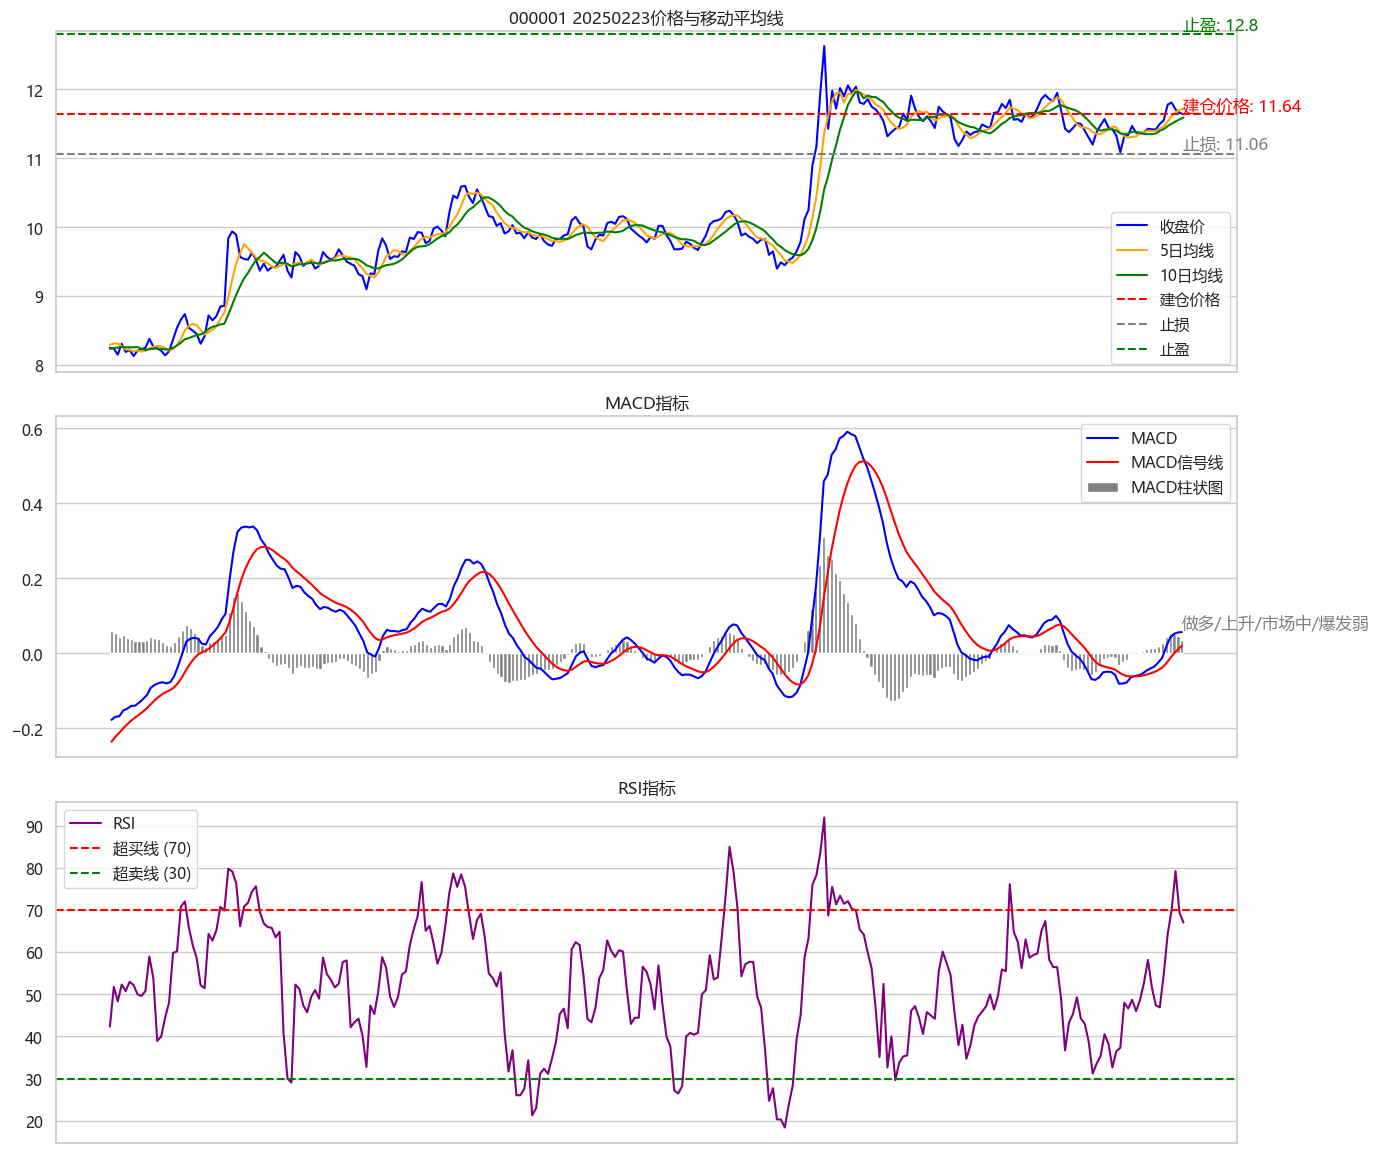

In [13]:
# 示例：获取某股票的最新数据
stock_code = get_stock_input()  # 替换为具体股票代码
end_date_str = get_back_test_day_input()
df = get_stock_data(stock_code, '19000101', end_date_str)
df = pd.DataFrame(df)
df = calculate_technical_indicators(df)

market_status = market_analysis(df)
print("市场状态研判:", market_status)

trade_plan = trade_execution_plan(df, market_status)
print("交易执行方案:", trade_plan)

batch_plan = batch_entry_plan(df, trade_plan)
print("分批建仓计划:", batch_plan)

profit_plan = profit_taking_plan(trade_plan)
print("止盈加仓计划:", profit_plan)

risk_plan = risk_management_plan()
print("风控方案:", risk_plan)

plot_market_analysis(df,trade_plan)